In [8]:
!pip install matplotlib

Looking in links: /cvmfs/soft.computecanada.ca/custom/python/wheelhouse/gentoo2023/x86-64-v3, /cvmfs/soft.computecanada.ca/custom/python/wheelhouse/gentoo2023/generic, /cvmfs/soft.computecanada.ca/custom/python/wheelhouse/generic
Processing /cvmfs/soft.computecanada.ca/custom/python/wheelhouse/gentoo2023/x86-64-v3/matplotlib-3.10.0+computecanada-cp311-cp311-linux_x86_64.whl
Processing /cvmfs/soft.computecanada.ca/custom/python/wheelhouse/gentoo2023/generic/contourpy-1.3.1+computecanada-cp311-cp311-linux_x86_64.whl (from matplotlib)
Processing /cvmfs/soft.computecanada.ca/custom/python/wheelhouse/generic/cycler-0.12.1+computecanada-py3-none-any.whl (from matplotlib)
Processing /cvmfs/soft.computecanada.ca/custom/python/wheelhouse/generic/fonttools-4.57.0+computecanada-cp311-cp311-linux_x86_64.whl (from matplotlib)
Processing /cvmfs/soft.computecanada.ca/custom/python/wheelhouse/gentoo2023/x86-64-v3/kiwisolver-1.4.8+computecanada-cp311-cp311-linux_x86_64.whl (from matplotlib)
Processing 

In [5]:
import torch
from torch import nn
import torchvision.ops as ops

class ATSSMatcher:
    def __init__(self, top_k=9):
        self.top_k = top_k  # number of anchors to select per level

    def __call__(self, anchors_per_level, gt_boxes):
        """
        anchors_per_level: List[Tensor[N_i, 4]] in (x1, y1, x2, y2) format
        gt_boxes: Tensor[M, 4]
        Returns:
            matched_idxs: Tensor[N_total] with GT index or -1
            max_ious: Tensor[N_total]
        """
        num_gt = gt_boxes.size(0)
        all_anchors = torch.cat(anchors_per_level, dim=0)  # [N_total, 4]
        num_anchors = all_anchors.size(0)

        matched_idxs = torch.full((num_anchors,), -1, dtype=torch.long, device=gt_boxes.device)
        max_ious = torch.zeros(num_anchors, dtype=torch.float, device=gt_boxes.device)

        # 1. Compute IoU between all anchors and GTs
        ious = ops.box_iou(all_anchors, gt_boxes)  # [N_total, M]

        # 2. Compute anchor centers
        anchor_centers = (all_anchors[:, :2] + all_anchors[:, 2:]) / 2  # [N, 2]
        gt_centers = (gt_boxes[:, :2] + gt_boxes[:, 2:]) / 2  # [M, 2]

        for gt_idx in range(num_gt):
            gt_box = gt_boxes[gt_idx]
            gt_center = gt_centers[gt_idx]  # [2]

            # Distance from GT center to anchor centers
            distances = torch.norm(anchor_centers - gt_center[None, :], dim=1)  # [N]

            # Pick top-k closest anchors
            topk_idxs = torch.topk(distances, self.top_k, largest=False).indices  # [top_k]

            topk_ious = ious[topk_idxs, gt_idx]
            iou_mean = topk_ious.mean()
            iou_std = topk_ious.std()
            dynamic_thresh = iou_mean + iou_std

            # Positive = anchors with IoU >= dynamic_thresh and inside GT
            candidate_mask = ious[:, gt_idx] >= dynamic_thresh

            inside_gt = self.anchor_inside_box(all_anchors, gt_box)
            pos_mask = candidate_mask & inside_gt  # [N]

            pos_indices = pos_mask.nonzero(as_tuple=False).squeeze(1)
            matched_idxs[pos_indices] = gt_idx
            max_ious[pos_indices] = ious[pos_indices, gt_idx]

        return matched_idxs, max_ious

    def anchor_inside_box(self, anchors, gt_box):
        """
        Return a mask of anchors whose center is inside the GT box.
        """
        cx = (anchors[:, 0] + anchors[:, 2]) / 2
        cy = (anchors[:, 1] + anchors[:, 3]) / 2

        return (
            (cx >= gt_box[0]) & (cx <= gt_box[2]) &
            (cy >= gt_box[1]) & (cy <= gt_box[3])
        )

In [ ]:

# Define synthetic anchor shapes (per FPN level)
anchor_shapes = {
    'P4': (16700, 4),
    'P5': (4200, 4),
    'P6': (1050, 4),
    'P7': (273, 4)
}

# Generate random anchors within a 512x512 image space
anchors_per_level = [torch.rand(shape) * 512 for shape in anchor_shapes.values()]

# Generate 5 synthetic ground truth boxes in (x1, y1, x2, y2) format
gt_boxes = torch.tensor([
    [50, 60, 150, 200],
    [220, 180, 300, 260],
    [100, 300, 180, 380],
    [350, 100, 450, 190],
    [400, 400, 500, 500]
], dtype=torch.float)

# Corresponding labels for the GT boxes
gt_labels = torch.tensor([1, 2, 1, 3, 2], dtype=torch.long)


In [6]:
# Step 4: Run the matcher
matcher = ATSSMatcher(top_k=9)
matched_idxs, max_ious = matcher(anchors_per_level, gt_boxes)

# Step 5: Print a quick summary
print(f"Total anchors: {matched_idxs.numel()}")
print(f"Matched (positive) anchors: {(matched_idxs != -1).sum().item()}")
print(f"Average IoU of positives: {max_ious[matched_idxs != -1].mean().item():.4f}")

Total anchors: 22223
Matched (positive) anchors: 728
Average IoU of positives: 0.2547


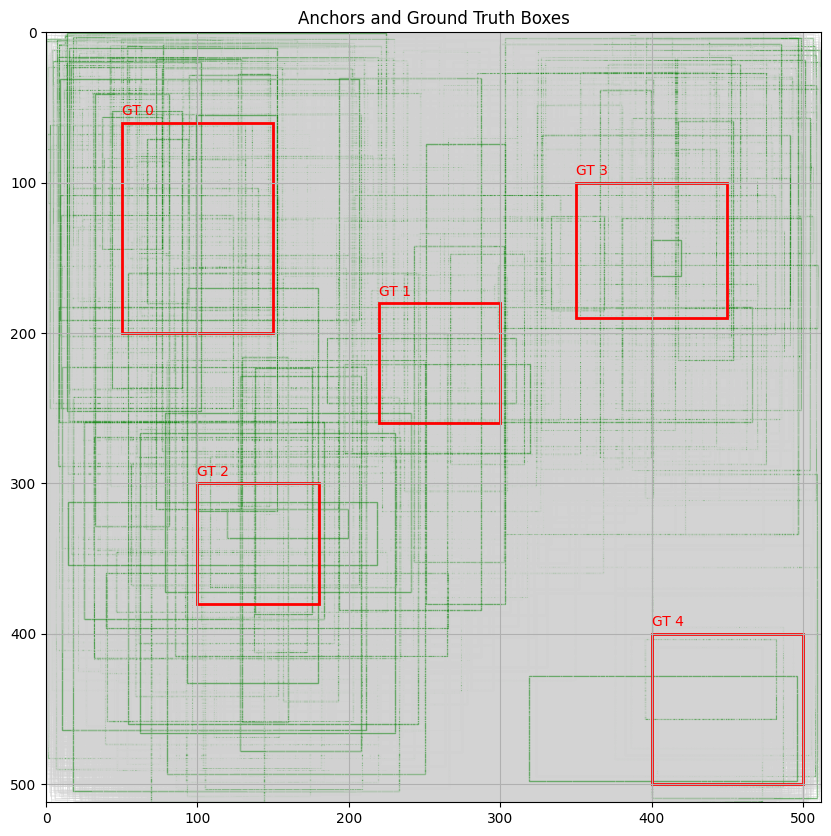

In [9]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def plot_anchors_and_gt(gt_boxes, anchors, matched_idxs):
    fig, ax = plt.subplots(figsize=(10, 10))
    
    # Draw all anchors (light gray)
    for i, anchor in enumerate(anchors):
        x1, y1, x2, y2 = anchor.tolist()
        color = 'green' if matched_idxs[i] != -1 else 'lightgray'
        linewidth = 0.5 if matched_idxs[i] == -1 else 1.0
        rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, 
                                 linewidth=linewidth, edgecolor=color, facecolor='none', alpha=0.5)
        ax.add_patch(rect)

    # Draw ground truth boxes (red)
    for i, gt in enumerate(gt_boxes):
        x1, y1, x2, y2 = gt.tolist()
        rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, 
                                 linewidth=2, edgecolor='red', facecolor='none')
        ax.add_patch(rect)
        ax.text(x1, y1 - 5, f'GT {i}', color='red', fontsize=10)

    ax.set_xlim(0, 512)
    ax.set_ylim(0, 512)
    ax.set_title("Anchors and Ground Truth Boxes")
    ax.invert_yaxis()
    plt.grid(True)
    plt.show()

# Call the function using all anchors and GTs
all_anchors = torch.cat(anchors_per_level, dim=0)
plot_anchors_and_gt(gt_boxes, all_anchors, matched_idxs)
